In [270]:
%matplotlib inline
import numpy as np
from scipy import signal
from matplotlib import pyplot as plt

In [271]:
plt.rcParams.update({'font.size':20})

In [605]:
# Configuration Parameters
carrier_freq = 77 * 10**9 # 77 GHz
bandwidth = 0.5 * 10**9 # Chirp bandwidth
chirp_period = 60 * 10**(-6) # in seconds
num_chirps = 30 # number of chirps in a frame
chirp_rate = bandwidth / chirp_period # i.e. alpha
print(chirp_rate)
freq_sample = 3000 * 10**3 # 3 Msps
range_fft_size = 128
doppler_fft_size = 16
noise_sigma = 1

num_samples = round(num_chirps * freq_sample * chirp_period)
print(num_samples)
chirp_timesteps = int(num_samples / num_chirps) # period of chirp in number of timesteps
print(chirp_timesteps)

8333333333333.334
5400
180


In [606]:
time_steps = np.linspace(0, chirp_period * num_chirps, num_samples)
time_inc = chirp_period * num_chirps / num_samples

In [607]:
freq = carrier_freq + chirp_rate * (time_steps - chirp_period * np.repeat(np.arange(num_chirps), chirp_timesteps))

Text(0.5, 1.0, 'Sawtooth Frequency Modulation')

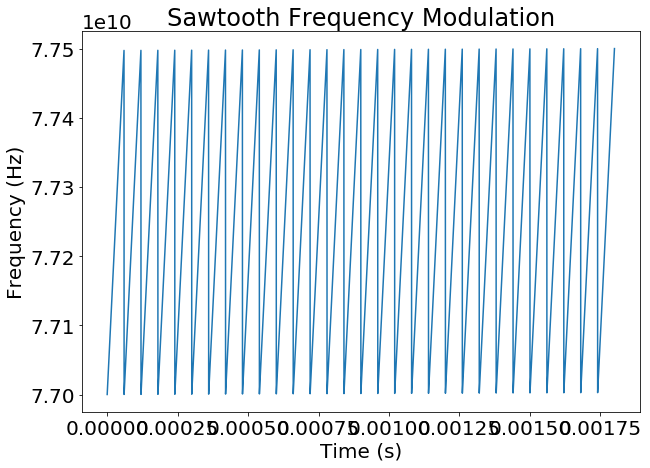

In [608]:
plt.figure(figsize=(10,7))
plt.plot(time_steps, freq)
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.title('Sawtooth Frequency Modulation')

In [609]:
transmitted = np.exp(1j * 2 * np.pi * freq * time_steps)

In [610]:
num_targets = 3
init_pos = [5, 10, 20]
velocities = [0, 5, -7.5]
init_tau = 2 * np.asarray(init_pos) / (3*10**8)

assert num_targets == len(init_pos)
assert num_targets == len(velocities)

received = np.zeros_like(transmitted)
for target in range(num_targets):
    init_distance = init_pos[target]
    velocity = velocities[target]
    distance = init_distance + velocity * time_steps
    print('Starting position: {}, Ending position: {}'.format(distance[0], distance[-1]))
    tau = 2 * distance / (3 * 10**8)
    delayed = np.exp(1j * 2 * np.pi * freq * (time_steps - tau))
    received += delayed + noise_sigma * np.random.randn(delayed.size)

Starting position: 5.0, Ending position: 5.0
Starting position: 10.0, Ending position: 10.009
Starting position: 20.0, Ending position: 19.9865


In [611]:
dechirped = transmitted * np.conj(received)

Text(0.5, 1.0, 'Dechirped Signal')

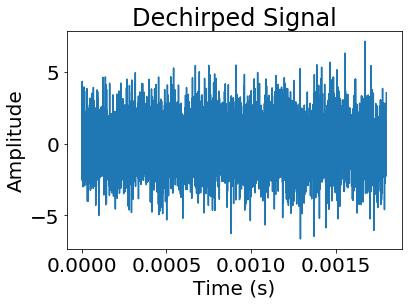

In [612]:
plt.plot(time_steps, dechirped)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Dechirped Signal')

In [613]:
chirp_number = 0
range_fft = np.fft.fft(dechirped[chirp_number * chirp_timesteps:(chirp_number + 1) * chirp_timesteps], n=range_fft_size)

In [614]:
peak_indices, _ = signal.find_peaks(np.abs(range_fft), height=100)
print(peak_indices)
freqs = np.arange(range_fft_size) / (time_inc * range_fft_size)
beat_freqs = freqs[peak_indices]
print(beat_freqs)
distances = freqs / chirp_rate * 3 * 10**8 / 2 # convert FFT bins to range distances
recovered_distances = distances[peak_indices]
print(recovered_distances)

[12 24 47]
[ 281250.   562500.  1101562.5]
[ 5.0625   10.125    19.828125]


In [615]:
distances

array([ 0.      ,  0.421875,  0.84375 ,  1.265625,  1.6875  ,  2.109375,
        2.53125 ,  2.953125,  3.375   ,  3.796875,  4.21875 ,  4.640625,
        5.0625  ,  5.484375,  5.90625 ,  6.328125,  6.75    ,  7.171875,
        7.59375 ,  8.015625,  8.4375  ,  8.859375,  9.28125 ,  9.703125,
       10.125   , 10.546875, 10.96875 , 11.390625, 11.8125  , 12.234375,
       12.65625 , 13.078125, 13.5     , 13.921875, 14.34375 , 14.765625,
       15.1875  , 15.609375, 16.03125 , 16.453125, 16.875   , 17.296875,
       17.71875 , 18.140625, 18.5625  , 18.984375, 19.40625 , 19.828125,
       20.25    , 20.671875, 21.09375 , 21.515625, 21.9375  , 22.359375,
       22.78125 , 23.203125, 23.625   , 24.046875, 24.46875 , 24.890625,
       25.3125  , 25.734375, 26.15625 , 26.578125, 27.      , 27.421875,
       27.84375 , 28.265625, 28.6875  , 29.109375, 29.53125 , 29.953125,
       30.375   , 30.796875, 31.21875 , 31.640625, 32.0625  , 32.484375,
       32.90625 , 33.328125, 33.75    , 34.171875, 

Text(0.5, 1.0, 'Range-FFT for a Single Chirp Period')

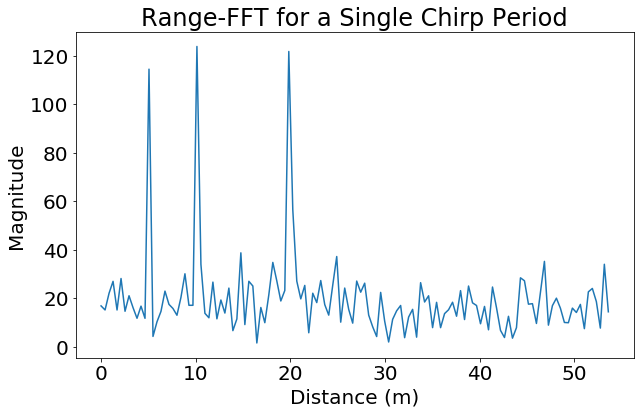

In [616]:
plt.figure(figsize=(10,6))
plt.plot(distances, np.abs(range_fft))
plt.xlabel('Distance (m)')
plt.ylabel('Magnitude')
plt.title('Range-FFT for a Single Chirp Period')

In [617]:
range_spectrum = range_fft.reshape((-1,1))
for n in range(1, num_chirps):
    range_spectrum = np.concatenate((range_spectrum,
                                    np.fft.fft(dechirped[n*chirp_timesteps:(n+1)*chirp_timesteps], n=range_fft_size).reshape((-1,1))),
                                   axis=1)
doppler_spectrum = np.fft.fftshift(np.fft.fft(range_spectrum, n=doppler_fft_size, axis=1), axes=1)

In [618]:
doppler_freqs = np.fft.fftfreq(doppler_fft_size, d=chirp_period)
velocities = np.fft.fftshift(doppler_freqs * 3 * 10**8 / 2 / carrier_freq)
print(velocities)
print(len(velocities))

[-16.23376623 -14.20454545 -12.17532468 -10.1461039   -8.11688312
  -6.08766234  -4.05844156  -2.02922078   0.           2.02922078
   4.05844156   6.08766234   8.11688312  10.1461039   12.17532468
  14.20454545]
16


Text(0.5, 1.0, 'Range-Doppler FFT')

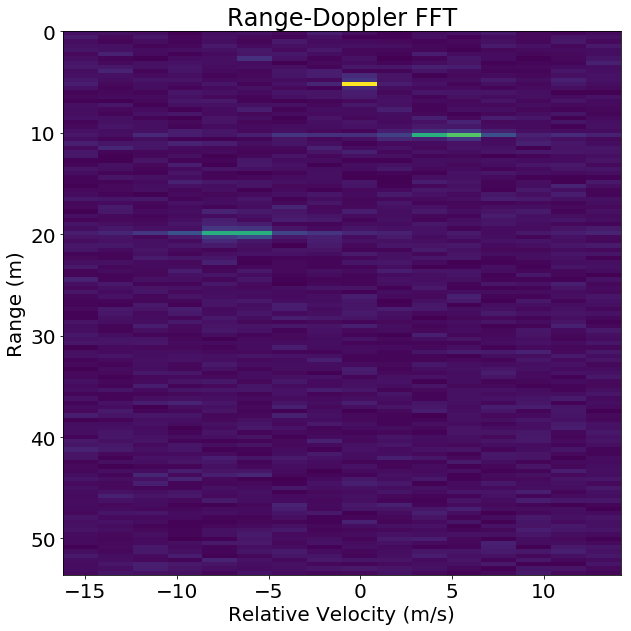

In [619]:
plt.figure(figsize=(10,10))
plt.imshow(np.abs(doppler_spectrum), 
           aspect='auto',
           extent=[velocities.min(), velocities.max(), distances.max(), distances.min()])
plt.xlabel('Relative Velocity (m/s)')
plt.ylabel('Range (m)')
plt.title('Range-Doppler FFT')

In [620]:
doppler_peaks = np.where(np.abs(doppler_spectrum) > 4000)
print(doppler_peaks)
recovered_velocities = velocities[doppler_peaks[1]]
recovered_dist = distances[doppler_peaks[0]]
print('Distances: {}'.format(recovered_dist))
print('Velocities: {}'.format(recovered_velocities))

(array([], dtype=int64), array([], dtype=int64))
Distances: []
Velocities: []
